# Training and Testing an MLP for Performance Prediction

In this notebook you will learn about training and testing a Multi Layer Perceptron (MLP). 
This will introduction 
you to (or refresh your knowledge about):
1. how to prepare your dataset, i.e., normalization, and performing the training, validation and testing splits; 
2. how define an MLP, including input size, hidden layers, output layer and activation functions;
3. how to train and validate your model by interpreting training and validation loss;
4. how to evaluate the trained model on the test set.

This notebook is developed using the open source machine learning framework PyTorch, however all machine 
learning concepts covered in this tutorial are applicable in all other machine learning frameworks. 

To experiment with this notebook use the button below to open it in Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aldolipani/ICIN20_ML4N_Tutorial/blob/master/2%20-%20Training%20and%20Testing%20an%20MLP.ipynb)

Now that you are in Colab, before getting started, let's execute the following code cell full of linux commands 
to make sure that all required packages and files are available in your workspace.

In [1]:
# these commands install PyTorch, Pandas, and a visualization tool that makes training ML models in a jupyter notebook beautiful!
!pip -q install torch torchvision
!pip -q install pandas==1.0
!pip -q install livelossplot

# this downloads the dataset
!wget https://raw.githubusercontent.com/aldolipani/ICIN20_ML4N_Tutorial/master/ps.csv

/bin/sh: wget: command not found


This will import all we need.

In [2]:
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from livelossplot import PlotLosses

from typing import List

## Loading the Dataset

In this notebook we will focus on the dataset generated using TODO

In [39]:
df = pd.read_csv('ps.csv')
del df['count']
del df['ref-cycles']
del df['task-clock']
del df['minor-faults']

data = df.to_numpy()

## Training, Validation and Test Sets


In [40]:
def train_validation_test_splits(data, train_size, validation_size):
    assert(train_size + validation_size < 1.0)
    # shuffling of the dataset
    np.random.shuffle(data)
    # extract the training portion
    n = int(train_size * len(data))
    train, rest = data[:n,:], data[n:,:]
    # from the remaining examples, we extract the validation and test portions
    n = int(validation_size * len(data))
    validation, test = rest[:n,:], rest[n:,:]
    return train, validation, test

train, validation, test = train_validation_test_splits(data, 0.8, 0.1)

print('The number of examples in the original dataset is ' + str(data.shape[0]))

print('The training-set has ' + str(train.shape[0]) + ' examples')
print('The validation-set has ' + str(validation.shape[0]) + ' exampels')
print('The test-set has ' + str(test.shape[0]) + ' examples')

The number of examples in the original dataset is 29967
The training-set has 23973 examples
The validation-set has 2996 exampels
The test-set has 2998 examples


At this point we have our datasets 

In [41]:
train_x, train_y = np.hsplit(train, [train.shape[1] - 1])
train_y = train_y.reshape(-1).astype(int)

validation_x, validation_y = np.hsplit(validation, [validation.shape[1] - 1])
validation_y = validation_y.reshape(-1).astype(int)

test_x, test_y = np.hsplit(test, [test.shape[1] - 1])
test_y = test_y.reshape(-1).astype(int)

In [42]:
min = train_x.min(axis=0)
max = train_x.max(axis=0)

train_x = (train_x - min)/(max - min)
validation_x = (validation_x - min)/(max - min)
test_x = (test_x - min)/(max - min)

In [43]:
#train_x

In [44]:
class MLP(nn.Module):
    
    def __init__(self, input_size:int=10, hidden:List[int]=[10, 20, 30], output_size:int = 3):
        super(MLP, self).__init__()
        self.fcs = nn.ModuleList()
        output_sizes = hidden + [output_size]
        print(output_sizes)
        for output_size in output_sizes:
            self.fcs.append(nn.Linear(input_size, output_size))
            input_size = output_size
        
    def forward(self, x):
        for fc in self.fcs:
            y = F.sigmoid(fc(x))
            x = y
        y = F.softmax(y)
        return y
        
        

In [45]:
model = MLP(28, [10], 3)
model = model.double()
model.parameters()

[10, 3]


<generator object Module.parameters at 0x1343bcc50>

In [46]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [47]:
batch_size = 32

train_dataset = TensorDataset(
    torch.from_numpy(train_x).double(), 
    torch.from_numpy(train_y))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = TensorDataset(
    torch.from_numpy(validation_x).double(), 
    torch.from_numpy(validation_y))
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


test_dataset = TensorDataset(
    torch.from_numpy(test_x).double(), 
    torch.from_numpy(test_y))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
liveloss = PlotLosses()

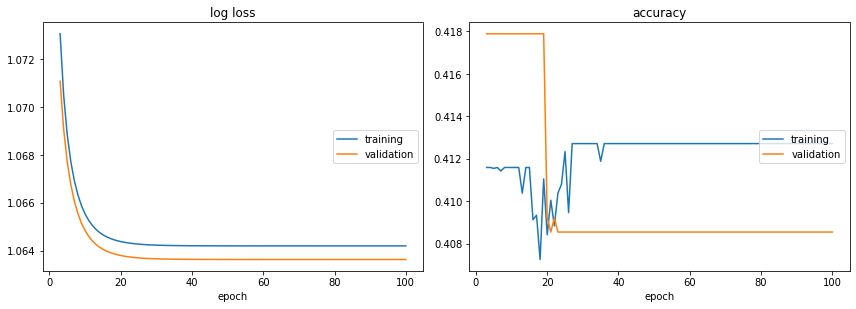

log loss:
training   (min:    1.064, max:    1.087, cur:    1.064)
validation (min:    1.064, max:    1.081, cur:    1.064)

accuracy:
training   (min:    0.407, max:    0.413, cur:    0.413)
validation (min:    0.409, max:    0.418, cur:    0.409)


In [49]:
epochs = 100

data_loader = {'train':train_loader, 'validation':validation_loader}

for epoch in range(epochs):  # loop over the dataset multiple times
    
    logs = {}
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        for i, batch in enumerate(data_loader[phase]):
            x, y = batch
            
            # forward + backward + optimize
            y_pred = model(x)
            # compute loss
            loss = criterion(y_pred, y)
            
            if phase == 'train':
                # reset optimizer
                optimizer.zero_grad()
                # backward step
                loss.backward()
                # update weights
                optimizer.step()
            
            # print statistics
            _, y_pred = torch.max(y_pred.detach(), 1)
            running_loss += loss.detach() * x.size(0)    
            running_corrects += torch.sum(y_pred == y)
        
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'
        
        epoch_loss = running_loss / len(data_loader[phase].dataset)
        logs[prefix + 'log loss'] = epoch_loss.item()
        epoch_acc = running_corrects.float() / len(data_loader[phase].dataset)
        logs[prefix + 'accuracy'] = epoch_acc.item()
    
    liveloss.update(logs)
    liveloss.draw()

In [46]:
model.eval()

running_loss = 0.0
running_corrects = 0
for i, batch in enumerate(test_loader):
    x, y = batch
    y_pred = model(x)
    _, y_pred = torch.max(y_pred.detach(), 1)
    running_corrects += torch.sum(y_pred == y)

acc = running_corrects.float() / len(data_loader[phase].dataset)
print(acc)

tensor(0.7086)


/Users/ucaclip/opt/anaconda3/envs/ml4n/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/ucaclip/opt/anaconda3/envs/ml4n/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
